In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

# Define dataset path
dataset_path = "/content/drive/MyDrive/IAM/archive (1).zip"
extract_path = "/content/iam_dataset/"

# Extract dataset
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Dataset extracted successfully.")

Dataset extracted successfully.


In [ ]:
!pip install -q transformers datasets jiwer

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 15.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 12.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 66.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 17.3 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.

In [ ]:

import pandas as pd

# Load dataset
gt_file = os.path.join(extract_path, "IAM/gt_test.txt")
df = pd.read_fwf(gt_file, header=None)
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)
del df[2]
df['file_name'] = df['file_name'].apply(lambda x: x + 'g' if x.endswith('jp') else x)
df.head()

,file_name,text
0,c04-110-00.jpg,Become a success with a disc and hey presto ! ...
1,c04-110-01.jpg,"assuredness "" Bella Bella Marie "" ( Parlophone..."
2,c04-110-02.jpg,I don't think he will storm the charts with th...
3,c04-110-03.jpg,"CHRIS CHARLES , 39 , who lives in Stockton-on-..."
4,c04-116-00.jpg,He is also a director of a couple of garages ....


In [ ]:

from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2)
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [ ]:
import torch
from torch.utils.data import Dataset
from PIL import Image
from transformers import TrOCRProcessor

class IAMDataset(Dataset):
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        file_name = self.df['file_name'][idx]
        text = self.df['text'][idx]
        image_path = os.path.join(self.root_dir, file_name)
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        labels = self.processor.tokenizer(text, padding="max_length", max_length=self.max_target_length).input_ids
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]
        return {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
image_dir = os.path.join(extract_path, "IAM/image/")

train_dataset = IAMDataset(root_dir=image_dir, df=train_df, processor=processor)
eval_dataset = IAMDataset(root_dir=image_dir, df=test_df, processor=processor)

print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

Number of training examples: 2332
Number of validation examples: 583


In [ ]:

from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-stage1")
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
model.config.vocab_size = model.config.decoder.vocab_size
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

config.json:   0%|          | 0.00/4.21k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    num_train_epochs=20,
    predict_with_generate=True,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=True,
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.8 MB/s eta 0:00:00


In [ ]:
from evaluate import load

cer_metric = load("cer")

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions
    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)
    return {"cer": cer_metric.compute(predictions=pred_str, references=label_str)}

In [ ]:
from transformers import default_data_collator

trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.feature_extractor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/transformers/models/trocr/processing_trocr.py:152: FutureWarning: `feature_extractor` is deprecated and will be removed in v5. Use `image_processor` instead.
  warnings.warn(
<ipython-input-9-fefca6e3307e>:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: ahsanejazbutt420 (ahsanejazbutt420-pmas-arid-agriculture-university-rawalpindi) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


`loss_type=None` was set in the config but it is unrecognised.Using the default loss: `ForCausalLMLoss`.


Step,Training Loss,Validation Loss,Cer
200,3.785600,4.011684,0.601207
400,3.979500,3.891493,0.582736
600,2.205400,3.165362,0.612877
800,2.523100,3.437393,0.590946
1000,1.373500,3.075313,0.561207
1200,1.296200,2.981654,0.573481
1400,1.573700,2.937211,0.548974
1600,0.805300,2.851311,0.570262
1800,0.752400,2.860734,0.551590
2000,1.019200,2.740054,0.550543


/usr/local/lib/python3.11/dist-packages/transformers/generation/utils.py:1581: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed in v5. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3353: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=5840, training_loss=0.9721058489882375, metrics={'train_runtime': 7450.9554, 'train_samples_per_second': 6.26, 'train_steps_per_second': 0.784, 'total_flos': 4.12715238188227e+19, 'train_loss': 0.9721058489882375, 'epoch': 20.0})

In [ ]:
import os

# Define the path where the model will be saved
save_directory = "/content/drive/MyDrive/TRocR_oneline_1line"

# Create the directory if it does not exist
os.makedirs(save_directory, exist_ok=True)

# Save the trained model
model.save_pretrained(save_directory)
processor.save_pretrained(save_directory)


[]

In [ ]:
from transformers import VisionEncoderDecoderModel, TrOCRProcessor

# Load the saved model and processor
model = VisionEncoderDecoderModel.from_pretrained(save_directory)
processor = TrOCRProcessor.from_pretrained(save_directory)


Config of the encoder: <class 'transformers.models.vit.modeling_vit.ViTModel'> is overwritten by shared encoder config: ViTConfig {
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "image_size": 384,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "model_type": "vit",
  "num_attention_heads": 12,
  "num_channels": 3,
  "num_hidden_layers": 12,
  "patch_size": 16,
  "pooler_act": "tanh",
  "pooler_output_size": 768,
  "qkv_bias": false,
  "torch_dtype": "float32",
  "transformers_version": "4.50.3"
}

Config of the decoder: <class 'transformers.models.trocr.modeling_trocr.TrOCRForCausalLM'> is overwritten by shared decoder config: TrOCRConfig {
  "activation_dropout": 0.0,
  "activation_function": "relu",
  "add_cross_attention": true,
  "attention_dropout": 0.0,
  "bos_token_id": 0,
  "classifier_dropout": 0.0,
  "cross_attention_hidden_size": 768,
  "d_mod

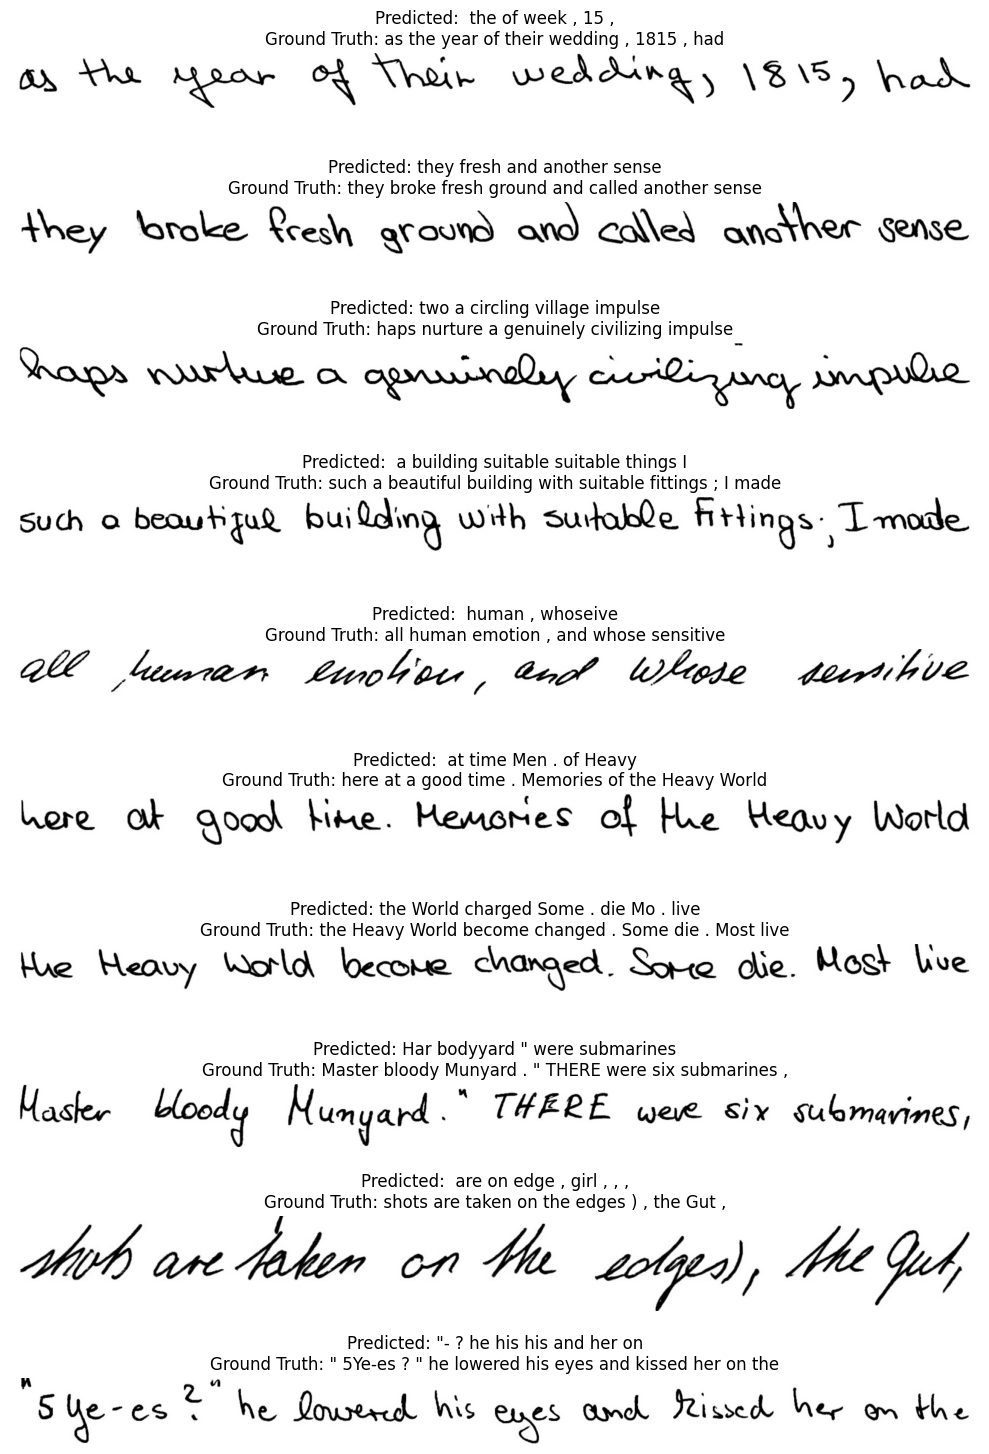

In [ ]:
import matplotlib.pyplot as plt

# Select 5 images from validation set
num_samples = 10
sample_indices = test_df.sample(num_samples).index.tolist()

fig, axes = plt.subplots(num_samples, 1, figsize=(10, 15))

for i, idx in enumerate(sample_indices):
    # Load image
    image_path = os.path.join('/content/iam_dataset/IAM/image', test_df.loc[idx, 'file_name'])
    image = Image.open(image_path).convert("RGB")

    # Process the image
    pixel_values = processor(image, return_tensors="pt").pixel_values

    # Get predictions
    with torch.no_grad():
        generated_ids = model.generate(pixel_values)
    predicted_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    # Get ground truth text
    ground_truth = test_df.loc[idx, 'text']

    # Plot image with prediction
    axes[i].imshow(image)
    axes[i].axis("off")
    axes[i].set_title(f"Predicted: {predicted_text}\nGround Truth: {ground_truth}", fontsize=12)

plt.tight_layout()
plt.show()


In [ ]:
!git clone https://github.com/arshjot/Handwritten-Text-Recognition

Cloning into 'Handwritten-Text-Recognition'...
remote: Enumerating objects: 606, done.
remote: Counting objects: 100% (102/102), done.
remote: Compressing objects: 100% (46/46), done.
remote: Total 606 (delta 44), reused 102 (delta 44), pack-reused 504 (from 1)
Receiving objects: 100% (606/606), 643.87 KiB | 9.33 MiB/s, done.
Resolving deltas: 100% (273/273), done.


In [ ]:
%cd Handwritten-Text-Recognition

/content/Handwritten-Text-Recognition/mains/Handwritten-Text-Recognition


In [ ]:
!cp /content/drive/MyDrive/CRNN_h128.tar.xz .

In [ ]:
!tar -tf CRNN_h128.tar.xz

CRNN_h128/
CRNN_h128/summary/
CRNN_h128/summary/events.out.tfevents.1571916187.arsh-PC
CRNN_h128/summary/events.out.tfevents.1571965819.arsh-PC
CRNN_h128/checkpoint/
CRNN_h128/checkpoint/-154050.data-00000-of-00001
CRNN_h128/checkpoint/-154050.meta
CRNN_h128/checkpoint/-154050.index
CRNN_h128/checkpoint/checkpoint
CRNN_h128/best_model/
CRNN_h128/best_model/-140181.meta
CRNN_h128/best_model/-140181.data-00000-of-00001
CRNN_h128/best_model/-140181.index
CRNN_h128/best_model/checkpoint


In [ ]:
!mkdir -p experiments
!tar -xJf CRNN_h128.tar.xz -C experiments/

In [ ]:
# !mkdir -p experiments/CRNN_h128
# !tar -xJf CRNN_h128.tar.xz -C experiments/CRNN_h128/

tar (child): CRNN_h128.tar.xz: Cannot open: No such file or directory
tar (child): Error is not recoverable: exiting now
tar: Child returned status 2
tar: Error is not recoverable: exiting now


In [ ]:
!ls experiments/CRNN_h128/

best_model  checkpoint	summary


In [ ]:
import json

# Load the config file
with open('configs/config.json', 'r') as f:
    config = json.load(f)

# Set batch size to 1 for inference
if 'batch_size' in config:
    config['batch_size'] = 1
else:
    # If 'batch_size' isn't found, inspect the file to find the correct key
    print("Please check 'configs/config.json' for the correct batch size key.")
    print(config)

# Save the updated config
with open('configs/config.json', 'w') as f:
    json.dump(config, f)

print("Configuration updated successfully!")

Configuration updated successfully!


In [ ]:
!mkdir -p samples

In [ ]:
!unzip -j "/content/drive/MyDrive/IAM/archive (1).zip" -d samples/

Archive:  /content/drive/MyDrive/IAM/archive (1).zip
  inflating: samples/gpt2.dict.txt   
  inflating: samples/gt_test.txt     
  inflating: samples/c04-110-00.jpg  
  inflating: samples/c04-110-01.jpg  
  inflating: samples/c04-110-02.jpg  
  inflating: samples/c04-110-03.jpg  
  inflating: samples/c04-116-00.jpg  
  inflating: samples/c04-116-01.jpg  
  inflating: samples/c04-116-02.jpg  
  inflating: samples/c04-116-03.jpg  
  inflating: samples/c04-134-00.jpg  
  inflating: samples/c04-134-01.jpg  
  inflating: samples/c04-134-02.jpg  
  inflating: samples/c04-134-03.jpg  
  inflating: samples/c04-134-04.jpg  
  inflating: samples/c04-134-05.jpg  
  inflating: samples/c04-134-06.jpg  
  inflating: samples/c04-139-00.jpg  
  inflating: samples/c04-139-01.jpg  
  inflating: samples/c04-139-02.jpg  
  inflating: samples/c04-139-03.jpg  
  inflating: samples/c04-139-04.jpg  
  inflating: samples/c04-139-05.jpg  
  inflating: samples/c04-139-06.jpg  
  inflating: samples/c04-144-00.jpg

In [ ]:
!ls samples/

c04-110-00.jpg	d07-093-08.jpg	 g01-016-02.jpg      m04-038-02.jpg  n04-092-01.jpg
c04-110-01.jpg	d07-096-00.jpg	 g01-016-03.jpg      m04-038-03.jpg  n04-092-02.jpg
c04-110-02.jpg	d07-096-01.jpg	 g01-016-04.jpg      m04-038-04.jpg  n04-092-03.jpg
c04-110-03.jpg	d07-096-02.jpg	 g01-016-05.jpg      m04-038-05.jpg  n04-092-04.jpg
c04-116-00.jpg	d07-096-03.jpg	 g01-016-06.jpg      m04-043-00.jpg  n04-092-05.jpg
c04-116-01.jpg	d07-096-04.jpg	 g01-016-07.jpg      m04-043-01.jpg  n04-092-06.jpg
c04-116-02.jpg	d07-096-05.jpg	 g01-019-00.jpg      m04-043-02.jpg  n04-092-07.jpg
c04-116-03.jpg	d07-096-06.jpg	 g01-019-01.jpg      m04-043-03.jpg  n04-092-08.jpg
c04-134-00.jpg	d07-096-07.jpg	 g01-019-02.jpg      m04-043-04.jpg  n04-100-00.jpg
c04-134-01.jpg	d07-096-08.jpg	 g01-019-03.jpg      m04-061-00.jpg  n04-100-01.jpg
c04-134-02.jpg	d07-096-09.jpg	 g01-019-04.jpg      m04-061-01.jpg  n04-100-02.jpg
c04-134-03.jpg	d07-100-00.jpg	 g01-019-05.jpg      m04-061-02.jpg  n04-100-03.jpg
c04-134-04.jpg	d

In [ ]:
!apt-get update
!apt-get install imagemagick

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Get:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:6 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,383 kB]
Get:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease [18.1 kB]
Hit:10 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:11 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,684 kB]
Get:13 http://archive.ubuntu.com/ubunt

In [ ]:
!convert --version

Version: ImageMagick 6.9.11-60 Q16 x86_64 2021-01-25 https://imagemagick.org
Copyright: (C) 1999-2021 ImageMagick Studio LLC
License: https://imagemagick.org/script/license.php
Features: Cipher DPC Modules OpenMP(4.5) 
Delegates (built-in): bzlib djvu fftw fontconfig freetype heic jbig jng jp2 jpeg lcms lqr ltdl lzma openexr pangocairo png tiff webp wmf x xml zlib


In [ ]:
!chmod +x imgtxtenh  # Make it executable if it’s a binary or script

chmod: cannot access 'imgtxtenh': No such file or directory


In [ ]:
!pip install Pillow

In [ ]:
%cd mains
!python predict.py -c ../configs/config.json

[Errno 2] No such file or directory: 'mains'
/content/Handwritten-Text-Recognition/mains/Handwritten-Text-Recognition/mains
2025-04-09 12:33:11.737482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744201991.845164   17907 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744201991.862842   17907 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-09 12:33:11.946894: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
P